In [15]:
import hashlib
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import math


class TimeIntervalWatermark:

    # 初始化
    def __init__(self, seed_interval_count: int = 3, nearby_green_count: int = 3, 
                 original_green_ratio: float = 0.5, change_pro: float = 1, balance_threshold: float = 0.40, threshold: float = 0.75):
        self.seed_interval_count = seed_interval_count  # 用于生成种子的时间间隔数量
        self.nearby_green_count = nearby_green_count  # 修改红色区间时，选择的邻近绿色区间数量
        self.original_green_ratio = original_green_ratio  # 初始绿色区间比例
        self.change_prob = change_pro  # 红色区间修改为绿色的几率
        self.balance_threshold = balance_threshold
        self.threshold = threshold
        self.bins = []  # 时间区间列表
        self.time = 10  # 时间区间长度ms
        self.discrete_values = []  # 对应的离散值
        self.bin_colors = {}  # 区间颜色映射
        self.bin_data_count = {}  # 每个区间的数据计数
        self.active_bins = set()  # 有数据的区间集合
        self.min_value = 0  # 数据最小值
        self.max_value = 0  # 数据最大值

    # 根据数据计算时间区间列表
    def _calculate_bins(self, data: List[float]) -> None:
        
        # 保存最小值和最大值，用于检测时重建相同的区间
        self.min_value = min(data)
        self.max_value = max(data)

        min_bin = int(self.min_value / self.time) * self.time
        max_bin = (int(self.max_value / self.time) + 1) * self.time
        
        # 划分时间区间列表
        self.bins = list(range(min_bin, max_bin + self.time, self.time))
        # 生成对应的离散值
        self.discrete_values = [bin_val // self.time for bin_val in self.bins]
        
        # 统计每个区间的数据数量
        self.bin_data_count = {i: 0 for i in range(len(self.bins) - 1)}
        for val in data:
            discrete_val = self._get_discrete_value(val)
            bin_idx = self._get_bin_index(discrete_val)
            if 0 <= bin_idx < len(self.bins) - 1:
                self.bin_data_count[bin_idx] = self.bin_data_count.get(bin_idx, 0) + 1
        
        # 确定有数据的区间
        self.active_bins = {idx for idx, count in self.bin_data_count.items() if count > 0}
        
        # 确保最小值和最大值所在区间被保护
        min_bin_idx = self._get_bin_index(self._get_discrete_value(self.min_value))
        max_bin_idx = self._get_bin_index(self._get_discrete_value(self.max_value))
        if min_bin_idx >= 0 and min_bin_idx < len(self.bins) - 1:
            self.active_bins.add(min_bin_idx)
        if max_bin_idx >= 0 and max_bin_idx < len(self.bins) - 1:
            self.active_bins.add(max_bin_idx)

    # 获取时间间隔对应的离散值
    def _get_discrete_value(self, interval: float) -> int:
        return int(interval // self.time)

    # 获取离散值在区间列表中的索引
    def _get_bin_index(self, discrete_value: int) -> int:
        try:
            return self.discrete_values.index(discrete_value)
        except ValueError:
            # 如果不在列表中，返回最接近的索引
            closest_index = min(range(len(self.discrete_values)), 
                               key=lambda i: abs(self.discrete_values[i] - discrete_value))
            return closest_index

    # 检查给定值是否是最小值或最大值
    def _is_min_or_max_value(self, interval: float, original_data: List[float]) -> bool:
        min_val = self.min_value
        max_val = self.max_value
        # 考虑浮点数比较的精度问题
        epsilon = 1e-6
        return abs(interval - min_val) < epsilon or abs(interval - max_val) < epsilon

    # 根据前n个时间间隔生成哈希种子
    def _generate_seed(self, intervals: List[float]) -> int:
        if len(intervals) < self.seed_interval_count:
            # 如果数据不足，使用所有可用数据
            seed_intervals = intervals
        else:
            seed_intervals = intervals[:self.seed_interval_count]
        # 将浮点数转换为字符串并连接
        interval_str = "".join([str(int(i * 1000)) for i in seed_intervals])
        # 生成哈希值
        hash_value = hashlib.md5(interval_str.encode()).hexdigest()
        # 转换为整数作为种子
        return int(hash_value, 16) % (2**32)

    # 根据种子将区间分为红绿两类，只对有数据的区间进行分类
    def _classify_bins(self, seed: int) -> None:
        random.seed(seed)
        
        # 只对有数据的区间进行红绿色分配
        active_bin_list = list(self.active_bins)
        random.shuffle(active_bin_list)
        
        # 将一定比例作为绿色区间，剩余作为红色区间
        green_count = int(len(active_bin_list) * self.original_green_ratio)
        green_indices = set(active_bin_list[:green_count])
        
        # 创建区间颜色映射
        self.bin_colors = {}
        for i in range(len(self.bins) - 1):
            if i in green_indices:
                self.bin_colors[i] = "green"
            elif i in self.active_bins:
                self.bin_colors[i] = "red"
            else:
                self.bin_colors[i] = "gray"  # 无数据的区间标记为灰色

    # 找到附近的k个绿色区间
    def _find_nearby_green_bins(self, bin_index: int) -> List[int]:
        green_bins = [i for i, color in self.bin_colors.items() 
                     if color == "green" and i != bin_index and i in self.active_bins]
        
        if not green_bins:
            return []
        
        # 按照与当前区间的距离排序
        sorted_green_bins = sorted(green_bins, key=lambda x: abs(x - bin_index))
        return sorted_green_bins[:self.nearby_green_count]

    # 在指定区间内生成随机值
    def _get_random_value_in_bin(self, bin_index: int) -> float:
        bin_start = self.bins[bin_index]
        bin_end = self.bins[bin_index + 1]
        return random.uniform(bin_start, bin_end - 0.001)  # 避免取到上界

    # 在时间间隔数据中嵌入水印
    def embed_watermark(self, intervals: List[float]) -> List[float]:
        # 保存原始数据，用于后续验证
        original_intervals = intervals.copy()
        
        # 计算区间
        self._calculate_bins(intervals)
        
        # 生成种子
        seed = self._generate_seed(intervals)
        
        # 区间分类（嵌入前）
        self._classify_bins(seed)
        
        # 保存嵌入前的区间颜色
        original_bin_colors = self.bin_colors.copy()
        original_active_bins = self.active_bins.copy()
        
        # 准备嵌入水印
        watermarked_intervals = intervals.copy()
        
        # 保存每个区间的数据索引，用于验证修改后区间数据不为空
        bin_indices = {}
        for i, interval in enumerate(intervals):
            discrete_value = self._get_discrete_value(interval)
            bin_index = self._get_bin_index(discrete_value)
            if bin_index not in bin_indices:
                bin_indices[bin_index] = []
            bin_indices[bin_index].append(i)
        
        # 前n个用于种子生成的间隔保持不变
        for i in range(self.seed_interval_count, len(intervals)):
            interval = intervals[i]
            
            # 检查是否是最小值或最大值，如果是则跳过
            if self._is_min_or_max_value(interval, original_intervals):
                continue
                
            discrete_value = self._get_discrete_value(interval)
            bin_index = self._get_bin_index(discrete_value)
            
            # 只对红色区间进行修改，灰色区间不处理
            if bin_index < len(self.bins) - 1 and self.bin_colors.get(bin_index) == "red" and random.random() < self.change_prob:
                nearby_green_bins = self._find_nearby_green_bins(bin_index)
                if nearby_green_bins:
                    selected_bin = random.choice(nearby_green_bins)
                    # 检查修改后bin_index区间是否还有其他数据
                    if len(bin_indices[bin_index]) > 1:  # 还有其他数据，可以安全修改
                        watermarked_intervals[i] = self._get_random_value_in_bin(selected_bin)
                        bin_indices[bin_index].remove(i)  # 从原区间移除
                        if selected_bin not in bin_indices:
                            bin_indices[selected_bin] = []
                        bin_indices[selected_bin].append(i)  # 添加到新区间
        
        # 验证水印后的区间活跃状态
        temp_bin_data_count = {i: 0 for i in range(len(self.bins) - 1)}
        for val in watermarked_intervals:
            discrete_val = self._get_discrete_value(val)
            bin_idx = self._get_bin_index(discrete_val)
            if 0 <= bin_idx < len(self.bins) - 1:
                temp_bin_data_count[bin_idx] = temp_bin_data_count.get(bin_idx, 0) + 1
        
        temp_active_bins = {idx for idx, count in temp_bin_data_count.items() if count > 0}
        
        # 检查水印后是否有原来有数据的区间变为无数据
        for bin_idx in original_active_bins:
            if bin_idx not in temp_active_bins:
                print(f"警告：区间 {bin_idx} 在水印后变为无数据区间")

        # 统计水印后各区间的数据数量
        bin_data_count_after = {}
        total_data = 0
        for i, interval in enumerate(watermarked_intervals):
            discrete_value = self._get_discrete_value(interval)
            bin_index = self._get_bin_index(discrete_value)
            if bin_index < len(self.bins) - 1:
                bin_data_count_after[bin_index] = bin_data_count_after.get(bin_index, 0) + 1
                total_data += 1
        
        # 找出所有绿色区间
        green_bins = [bin_idx for bin_idx, color in self.bin_colors.items() 
                     if color == "green" and bin_idx in bin_data_count_after.keys()]
        
        # 找出所有红色区间（用于备选）
        red_bins = [bin_idx for bin_idx, color in self.bin_colors.items() 
                   if color == "red" and bin_idx < len(self.bins) - 1]
        
        if green_bins and total_data > 0:
            # 计算安全阈值上限（使用0.9作为安全系数）
            safe_threshold = self.balance_threshold * 0.9
            
            # 计算每个绿色区间的数据比例
            for bin_idx in green_bins:
                bin_ratio = bin_data_count_after.get(bin_idx, 0) / total_data
                
                # 如果某个绿色区间数据比例超过安全阈值，进行再平衡
                if bin_ratio > safe_threshold:
                    # 获取该区间中所有非种子、非极值数据的索引
                    adjustable_indices = []
                    for i in bin_indices.get(bin_idx, []):
                        if (i >= self.seed_interval_count and 
                            not self._is_min_or_max_value(watermarked_intervals[i], original_intervals)):
                            adjustable_indices.append(i)
                    
                    # 计算需要移出的数据量，使其刚好低于安全阈值
                    max_allowed_count = int(safe_threshold * total_data - 1)
                    excess_count = bin_data_count_after[bin_idx] - max_allowed_count
                    move_count = min(excess_count, len(adjustable_indices))
                    
                    # 随机选择需要移出的数据
                    if move_count > 0:
                        print("水印嵌入时检测到比例超过安全阈值，进行处理...")
                        indices_to_move = random.sample(adjustable_indices, move_count)
                        
                        # 计算每个可选目标绿色区间可以接收的最大数据量
                        target_green_bins = [b for b in green_bins if b != bin_idx]
                        max_capacity = {}
                        for target_bin in target_green_bins:
                            current_count = bin_data_count_after.get(target_bin, 0)
                            # 计算该区间还能接收多少数据而不超过安全阈值
                            max_capacity[target_bin] = max_allowed_count - current_count
                        
                        # 移动数据到其他绿色区间或红色区间
                        for idx in indices_to_move:
                            # 过滤出还有容量的目标绿色区间
                            available_targets = [bin_id for bin_id, capacity in max_capacity.items() if capacity > 0]
                            
                            if available_targets:
                                # 如果有可用的绿色区间，选择其中一个
                                target_bin = random.choice(available_targets)
                                
                                # 更新目标区间的数据量
                                watermarked_intervals[idx] = self._get_random_value_in_bin(target_bin)
                                
                                # 更新计数
                                bin_data_count_after[bin_idx] -= 1
                                bin_data_count_after[target_bin] = bin_data_count_after.get(target_bin, 0) + 1
                                max_capacity[target_bin] -= 1
                                
                                # 更新索引表
                                bin_indices[bin_idx].remove(idx)
                                if target_bin not in bin_indices:
                                    bin_indices[target_bin] = []
                                bin_indices[target_bin].append(idx)
                            elif red_bins:
                                # 如果没有可用的绿色区间，选择一个随机的红色区间
                                target_bin = random.choice(red_bins)
                                
                                # 更新到红色区间
                                watermarked_intervals[idx] = self._get_random_value_in_bin(target_bin)
                                
                                # 更新计数
                                bin_data_count_after[bin_idx] -= 1
                                bin_data_count_after[target_bin] = bin_data_count_after.get(target_bin, 0) + 1
                                
                                # 更新索引表
                                bin_indices[bin_idx].remove(idx)
                                if target_bin not in bin_indices:
                                    bin_indices[target_bin] = []
                                bin_indices[target_bin].append(idx)
                            else:
                                # 如果没有红色区间可用，保留在原区间
                                # 这种情况应该很少发生，因为正常情况下应该有红色区间
                                pass
        
        return watermarked_intervals

    # 检测是否存在水印，threshold为检测阈值
    def detect_watermark(self, intervals: List[float]) -> Tuple[bool, float]:
        # 计算区间
        self._calculate_bins(intervals)
        
        # 生成种子
        seed = self._generate_seed(intervals)
        
        # 区间分类
        self._classify_bins(seed)

        # 统计各区间数据量
        bin_data_count = {}
        total_data = 0
        for i in range(self.seed_interval_count, len(intervals)):
            interval = intervals[i]
            discrete_value = self._get_discrete_value(interval)
            bin_index = self._get_bin_index(discrete_value)
            
            if bin_index < len(self.bins) - 1:
                bin_data_count[bin_index] = bin_data_count.get(bin_index, 0) + 1
                total_data += 1
        
        # 检查是否存在异常分布的绿色区间
        green_bins = [bin_idx for bin_idx, color in self.bin_colors.items() if color == "green"]
        has_abnormal_distribution = False
        
        if total_data > 0:
            for bin_idx in green_bins:
                bin_ratio = bin_data_count.get(bin_idx, 0) / total_data
                if bin_ratio > self.balance_threshold:
                    has_abnormal_distribution = True
                    break
        # 如果存在异常分布，可能是未水印的自然流
        if has_abnormal_distribution:
            return False, 0.0
        
        # 统计绿色区间占比（只考虑红色和绿色区间，忽略灰色区间）
        green_count = 0
        total_count = 0
        red_count = 0
        
        # 跳过用于种子生成的数据
        for i in range(self.seed_interval_count, len(intervals)):
            interval = intervals[i]
            discrete_value = self._get_discrete_value(interval)
            bin_index = self._get_bin_index(discrete_value)
            
            if bin_index < len(self.bins) - 1:  # 确保索引有效
                color = self.bin_colors.get(bin_index)
                if color in ["green", "red"]:  # 只考虑红色和绿色区间
                    total_count += 1
                    if color == "green":
                        green_count += 1

        red_count = sum(1 for color in self.bin_colors.values() if color == "red")
        total_count = total_count - red_count
        green_count = green_count - red_count
                    
        green_ratio = green_count / total_count if total_count > 0 else 0
        
        return green_ratio >= self.threshold, green_ratio

    # 获取颜色列表，用于比较嵌入前后是否一致
    def get_bin_colors(self):
        return self.bin_colors
    
    # 可视化原始数据和水印数据的分布
    def visualize_data(self, original_intervals: List[float], watermarked_intervals: List[float]) -> None:
        plt.figure(figsize=(15, 12))
        
        # 1. 绘制原始数据和水印数据的直方图对比
        plt.figure(figsize=(10, 12))  # 增大图形尺寸以提高清晰度
        
        plt.subplot(3, 1, 1)
        # 使用与水印划分相同的bins参数，确保与下面的图表对齐
        hist_bins = self.bins  # 直接使用水印的bins
        plt.hist(original_intervals, bins=hist_bins, alpha=0.7, label="原始数据")
        plt.hist(watermarked_intervals, bins=hist_bins, alpha=0.7, label="水印数据")
        plt.legend()
        plt.title("时间间隔分布对比")
        plt.xlabel("时间间隔 (ms)")
        plt.ylabel("频率")
        
        # 2. 绘制区间数据分布
        plt.subplot(3, 1, 2)
        bin_centers = [(self.bins[i] + self.bins[i+1])/2 for i in range(len(self.bins)-1)]
        bin_counts = [self.bin_data_count.get(i, 0) for i in range(len(self.bins)-1)]
        plt.bar(bin_centers, bin_counts, width=self.time*0.8)
        plt.title("区间数据分布")
        plt.xlabel("时间间隔 (ms)")
        plt.ylabel("数据计数")
        
        # 3. 绘制时间区间颜色分类
        plt.subplot(3, 1, 3)
        bin_colors_list = []
        for i in range(len(self.bins)-1):
            color = self.bin_colors.get(i)
            if color == "green":
                bin_colors_list.append("green")
            elif color == "red":
                bin_colors_list.append("red")
            else:
                bin_colors_list.append("gray")  # 灰色表示无数据区间
                
        plt.bar(bin_centers, [1]*len(bin_centers), width=self.time*0.8, color=bin_colors_list, alpha=0.6)
        plt.title("区间颜色分类 (绿色: 绿色区间, 红色: 红色区间, 灰色: 无数据区间)")
        plt.xlabel("时间间隔 (ms)")
        
        plt.tight_layout()
        plt.show()
            
    # 比较嵌入水印前后的颜色列表
    def compare_bin_colors(self, intervals: List[float], watermarked_intervals: List[float]) -> bool:
        # 原始数据的颜色列表
        self._calculate_bins(intervals)
        seed = self._generate_seed(intervals)
        self._classify_bins(seed)
        original_colors = self.bin_colors.copy()
        original_active_bins = self.active_bins.copy()
        
        # 水印数据的颜色列表
        self._calculate_bins(watermarked_intervals)
        seed = self._generate_seed(watermarked_intervals)
        self._classify_bins(seed)
        watermarked_colors = self.bin_colors.copy()
        watermarked_active_bins = self.active_bins.copy()
        
        # 比较活跃区间
        active_bins_match = original_active_bins == watermarked_active_bins
        if not active_bins_match:
            print("警告：嵌入水印前后活跃区间不匹配")
            removed_bins = original_active_bins - watermarked_active_bins
            added_bins = watermarked_active_bins - original_active_bins
            if removed_bins:
                print(f"  水印后不再活跃的区间: {sorted(list(removed_bins))}")
            if added_bins:
                print(f"  水印后新增活跃的区间: {sorted(list(added_bins))}")
        
        # 比较颜色列表
        colors_match = True
        for bin_idx in original_active_bins.union(watermarked_active_bins):
            if original_colors.get(bin_idx) != watermarked_colors.get(bin_idx):
                colors_match = False
                print(f"区间 {bin_idx} 颜色不匹配: 原始={original_colors.get(bin_idx)}, 水印后={watermarked_colors.get(bin_idx)}")
        
        return active_bins_match and colors_match


# 读取时间间隔
def read_intervals(csv_file):
    df = pd.read_csv(csv_file)
    return df['interval_ms'].tolist()


def evaluate_watermark(watermark_system, original_data_dict, watermarked_data_dict,
                       watermarked_flows):
    # 初始化预测和真实标签列表
    y_true = []
    y_pred = []
    
    # 先检测所有嵌入水印的流
    for flow_id in watermarked_flows:
        intervals = watermarked_data_dict[flow_id]
        has_watermark, _ = watermark_system.detect_watermark(intervals)
        y_true.append(1)  # 应该有水印
        if (has_watermark != 1):
            print(f"水印流未检测出：{flow_id}")
        y_pred.append(1 if has_watermark else 0)
    
    # 检测所有未嵌入水印的流
    non_watermarked_flows = set(original_data_dict.keys()) - set(watermarked_flows)
    for flow_id in non_watermarked_flows:
        intervals = original_data_dict[flow_id]
        has_watermark, _ = watermark_system.detect_watermark(intervals)
        y_true.append(0)  # 应该没有水印
        if (has_watermark != 0):
            print(f"正常流误认为水印流：{flow_id}")
        y_pred.append(1 if has_watermark else 0)
    
    # 计算评价指标
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
# 设置支持中文的字体，比如 SimHei（黑体）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [13]:
def main():
    # 示例：读取所有流的时间间隔
    intervals_dir = "ssh_flows_20"
    all_intervals = {}

    # 检查目录是否存在
    if not os.path.exists(intervals_dir):
        print(f"目录 {intervals_dir} 不存在，使用随机生成的示例数据...")
        # 生成一些随机示例数据
        for i in range(64):
            flow_id = f"flow_{i+1}"
            # 生成偏斜分布的数据，造成大多数区间无数据的情况
            # 大部分数据集中在10-50ms，少部分在80-100ms之间，中间有很多空区间
            data = np.concatenate([
                np.random.uniform(10, 50, 800),  # 80%的数据集中在前面
                np.random.uniform(80, 100, 200)  # 20%的数据集中在后面
            ])
            all_intervals[flow_id] = data.tolist()
    else:
        # 读取实际数据
        for filename in os.listdir(intervals_dir):
            if filename.endswith('.csv'):
                flow_id = filename.split('.')[0]  # 获取不含扩展名的文件名
                file_path = os.path.join(intervals_dir, filename)
                all_intervals[flow_id] = read_intervals(file_path)
    
    # 创建水印系统
    watermark_system = TimeIntervalWatermark(seed_interval_count=3, nearby_green_count=3)
    
    # 显示流的总数
    print(f"共有 {len(all_intervals)} 个流")
    
    # 随机选择32个流进行水印嵌入
    flow_ids = list(all_intervals.keys())
    random.shuffle(flow_ids)
    watermarked_flows = set(flow_ids[:32])
    
    # 存储原始和水印后的数据
    original_data_dict = {}
    watermarked_data_dict = {}
    
    # 处理所有流
    for flow_id, intervals in all_intervals.items():
        print(f"处理流 {flow_id}，共有 {len(intervals)} 个时间间隔")
        original_data_dict[flow_id] = intervals
        
        if flow_id in watermarked_flows:
            # 嵌入水印
            print(f"嵌入水印到流 {flow_id}...")
            watermarked_data = watermark_system.embed_watermark(intervals)
            watermarked_data_dict[flow_id] = watermarked_data
            
            # 检测水印效果
            _, green_ratio_original = watermark_system.detect_watermark(intervals)
            has_watermark, green_ratio = watermark_system.detect_watermark(watermarked_data)
            
            print(f"原始数据绿色区间比例: {green_ratio_original:.2%}")
            print(f"水印数据绿色区间比例: {green_ratio:.2%}")
            print(f"水印嵌入结果: {'成功' if has_watermark else '失败'}")
            
            # 验证颜色列表是否匹配
            colors_match = watermark_system.compare_bin_colors(intervals, watermarked_data)
            print(f"颜色列表匹配: {'是' if colors_match else '否'}")

            # watermark_system.visualize_data(intervals, watermarked_data)
                
        else:
            # 不嵌入水印，但保持原始数据在词典中
            watermarked_data_dict[flow_id] = intervals
    
    # 评估水印性能
    evaluation_results = evaluate_watermark(
        watermark_system, original_data_dict, watermarked_data_dict, watermarked_flows
    )
    
    print("\n==== 水印系统性能评估 ====")
    print(f"准确率 (Accuracy): {evaluation_results['accuracy']:.4f}")
    print(f"精确率 (Precision): {evaluation_results['precision']:.4f}")
    print(f"召回率 (Recall): {evaluation_results['recall']:.4f}")
    print(f"F1分数 (F1-Score): {evaluation_results['f1']:.4f}")


if __name__ == "__main__":
    main()

共有 64 个流
处理流 flow_018_194，共有 54 个时间间隔
嵌入水印到流 flow_018_194...
水印嵌入时检测到比例超过安全阈值，进行处理...
原始数据绿色区间比例: 25.00%
水印数据绿色区间比例: 97.92%
水印嵌入结果: 成功
颜色列表匹配: 是
处理流 flow_044_216，共有 26 个时间间隔
嵌入水印到流 flow_044_216...
原始数据绿色区间比例: 5.26%
水印数据绿色区间比例: 84.21%
水印嵌入结果: 成功
颜色列表匹配: 是
处理流 flow_047_118，共有 20 个时间间隔
嵌入水印到流 flow_047_118...
原始数据绿色区间比例: 23.08%
水印数据绿色区间比例: 84.62%
水印嵌入结果: 成功
颜色列表匹配: 是
处理流 flow_013_60，共有 64 个时间间隔
处理流 flow_059_121，共有 27 个时间间隔
处理流 flow_060_203，共有 22 个时间间隔
嵌入水印到流 flow_060_203...
水印嵌入时检测到比例超过安全阈值，进行处理...
原始数据绿色区间比例: 0.00%
水印数据绿色区间比例: 64.29%
水印嵌入结果: 失败
颜色列表匹配: 是
处理流 flow_052_60，共有 42 个时间间隔
嵌入水印到流 flow_052_60...
水印嵌入时检测到比例超过安全阈值，进行处理...
原始数据绿色区间比例: 0.00%
水印数据绿色区间比例: 88.57%
水印嵌入结果: 成功
颜色列表匹配: 是
处理流 flow_020_126，共有 60 个时间间隔
嵌入水印到流 flow_020_126...
原始数据绿色区间比例: 38.10%
水印数据绿色区间比例: 69.05%
水印嵌入结果: 失败
颜色列表匹配: 是
处理流 flow_061_121，共有 23 个时间间隔
处理流 flow_037_101，共有 287 个时间间隔
处理流 flow_000_121，共有 14124 个时间间隔
处理流 flow_063_121，共有 19 个时间间隔
嵌入水印到流 flow_063_121...
水印嵌入时检测到比例超过安全阈值，进行处理...
原始数据绿色区间比例: 0.00%
水印数据绿色区间比例: 

水印嵌入时检测到比例超过安全阈值，进行处理...
水印嵌入时检测到比例超过安全阈值，进行处理...
颜色列表匹配: 是


<Figure size 1500x1200 with 0 Axes>

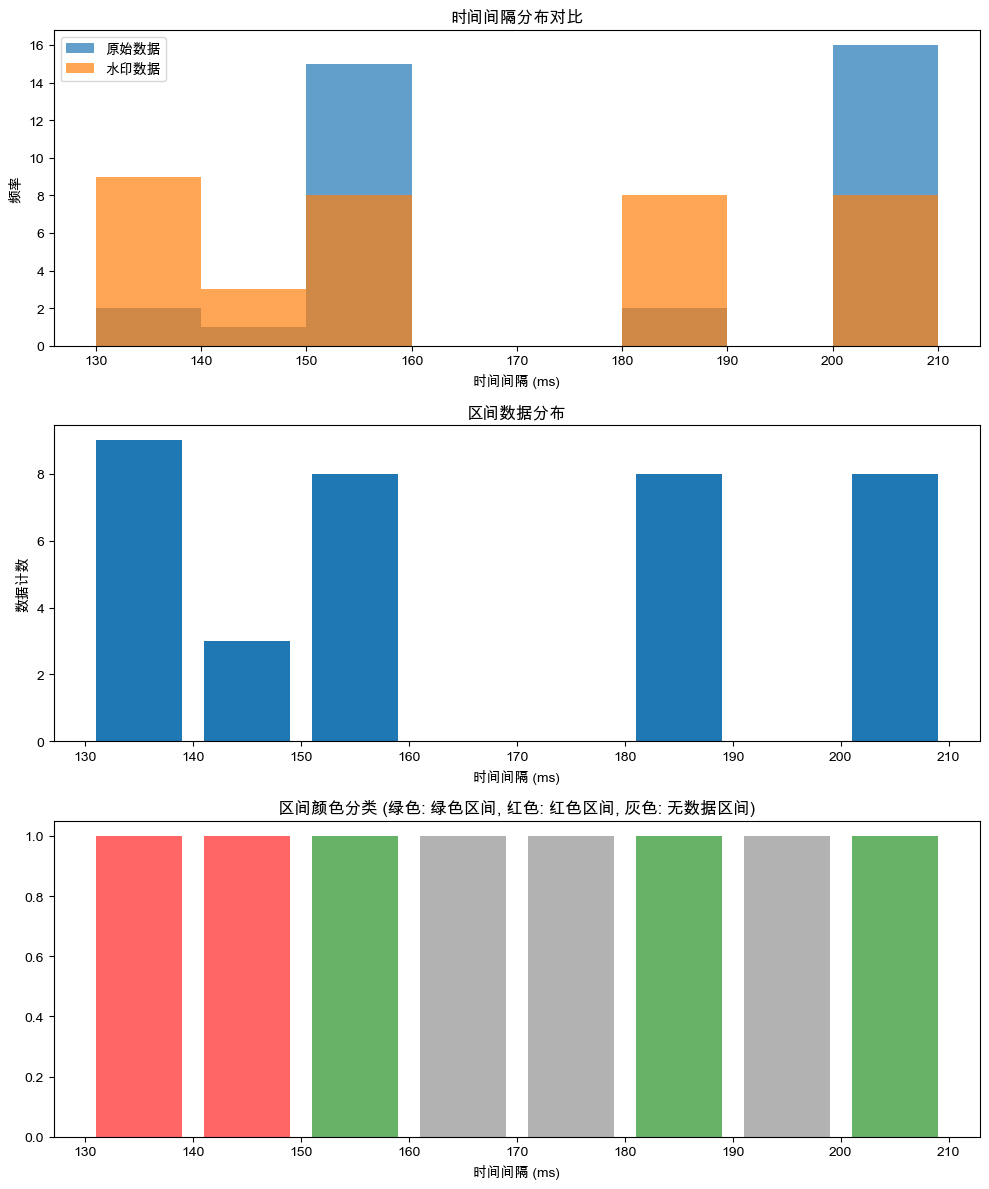

(False, 0.0)
(False, 0.6129032258064516)


In [273]:
intervals_dir = "ssh_flows_20"
all_intervals = {}
for filename in os.listdir(intervals_dir):
    if filename.endswith('.csv'):
        flow_id = filename.split('.')[0]  # 获取不含扩展名的文件名
        file_path = os.path.join(intervals_dir, filename)
        all_intervals[flow_id] = read_intervals(file_path)
# 创建水印系统
watermark_system = TimeIntervalWatermark(seed_interval_count=3, nearby_green_count=3)
intervals = all_intervals['flow_016_194']
watermarked_data = watermark_system.embed_watermark(intervals)
# 验证颜色列表是否匹配
colors_match = watermark_system.compare_bin_colors(intervals, watermarked_data)
print(f"颜色列表匹配: {'是' if colors_match else '否'}")
watermark_system.visualize_data(intervals, watermarked_data)
green_ratio_original = watermark_system.detect_watermark(intervals)
green_ratio = watermark_system.detect_watermark(watermarked_data)
print(green_ratio_original)
print(green_ratio)